# After sentiment analysis with Bert

final dataset - **'Merged_Reviews_All_Parts.csv'**

In [ ]:
import pandas as pd

In [ ]:
df_sent_ana_bert = pd.read_csv('Merged_Reviews_All_Parts.csv')

In [ ]:
df_sent_ana_bert.info()
df_sent_ana_bert.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1538680 entries, 0 to 1538679
Data columns (total 7 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   work                  1538680 non-null  int64  
 1   user                  1538680 non-null  object 
 2   stars                 1298896 non-null  float64
 3   time                  1538680 non-null  object 
 4   clean_comment         1538680 non-null  object 
 5   language              1538680 non-null  object 
 6   sentiment_score_bert  1538680 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 82.2+ MB


work                     446821
user                      78055
stars                        10
time                       2920
clean_comment           1538680
language                      6
sentiment_score_bert          5
dtype: int64

# SVD



*   Baseline - A standard Collaborative Filtering approach with
SVD was used as the baseline. Missing ratings were imputed
with the median, resulting in an RMSE of 0.883.
*   **Pre SVD algorithm Sentiment Analysis integration**
  - **Sentiment-Based Missing Value Imputation:** In this
experiment, sentiment scores were used only to impute
missing star ratings. The modified dataset, where actual
star ratings remained unchanged and only missing values
were replaced with sentiment scores, was passed to the
SVD model. The RMSE achieved was 0.883, which was
identical to the baseline, showing no improvement.

  - **Weighted Average of Sentiment Scores and Star Ratings:** This experiment aimed to use sentiment scores for
both missing and existing ratings. For missing values,
sentiment scores were directly used. For existing star
ratings, a weighted average of the stars and sentiment
scores was computed using a beta hyperparameter (β). The
modified ratings were then passed to the SVD model.

* **Post SVD algorithm Sentiment Analysis Integration**
  - **SVD Predictions Adjustment with Sentiment:** This
approach involved enhancing the SVD model’s predictions by adding sentiment scores to predictions. Initially,
missing star ratings were filled using the median, and the
modified dataset was used to train the SVD model. In
the second step, predictions from the SVD model were
adjusted by adding sentiment scores with a weighting
hyperparameter β.



In [ ]:
from surprise import Dataset, Reader, SVD
from surprise import accuracy
import pandas as pd
from sklearn.model_selection import train_test_split
from surprise.model_selection import GridSearchCV, cross_validate
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Step 1: Split the data
def custom_train_test_split(df):

    # Separate rows with NaN stars
    train_nan = df[df['stars'].isnull()]
    train_non_nan, test = train_test_split(df[df['stars'].notnull()], test_size=0.2, random_state=42)

    # Combine NaN stars with non-NaN train rows
    train = pd.concat([train_nan, train_non_nan])
    print(train.shape, test.shape)
    return train, test

# Step 2: Impute missing stars in the train set
def impute_missing_ratings(train, val='sentiment'):

    # Identify rows with missing stars before imputation
    # null_mask = train['stars'].isnull()

    if val == 'sentiment':
        # Fill missing values with sentiment_score_bert
        train['stars'] = train['stars'].fillna(train['sentiment_score_bert'])

    elif val == 'median':
        # Fill missing values with the median of stars
        med_val = train['stars'].median()
        print(f"Median value used for imputation: {med_val}")
        train['stars'] = train['stars'].fillna(med_val)

    else:
        raise ValueError("Invalid Value. Choose 'sentiment' or 'median'.")

    # Print rows that were initially null and are now imputed
    # imputed_rows = train[null_mask]

    # print(f"Rows imputed using {val}:\n",imputed_rows)

    return train


# Step 3: Train Surprise SVD
def svd_with_custom_split(train, test, cols=['user', 'work', 'stars']):

    # Define the Reader
    reader = Reader(rating_scale=(0.5, 5))

    # Convert to Surprise dataset format
    data = Dataset.load_from_df(train[cols], reader)

    test_data = list(test[cols].itertuples(index=False, name=None))

    # Define hyperparameter grid
    param_grid = {
        'n_factors': [15, 20, 40],
        "n_epochs": [10, 20],
        "lr_all": [0.005, 0.015],
        "reg_all": [0.04, 0.16]
    }

    # Perform grid search
    gs = GridSearchCV(SVD, param_grid, measures=['rmse', "mae"], cv=3, refit=True, n_jobs=-1, joblib_verbose=2)
    gs.fit(data)

    # Store results from grid search in a dataframe and Sort by RMSE score
#     gs_res_df = pd.DataFrame.from_dict(gs.cv_results)[[
#         "mean_test_rmse", "mean_test_mae", "param_n_factors",
#         "param_n_epochs", "param_lr_all", "param_reg_all"
#     ]].sort_values("mean_test_rmse")

  #  print(gs_res_df)

    # Get the best parameters
    best_params = gs.best_params['rmse']      #['mae']
    print(f"Best Parameters: {best_params}")

    # Train the best model on the entire train set
    train_data = data.build_full_trainset()

    print(f"Number of ratings in train set: {train_data.n_ratings}")
    print(f"Number of ratings in test set: {len(test)}")

    print('Training SVD model with best parameters . . . . ')
    best_model = SVD(**best_params)
    best_model.fit(train_data)

    # Test the model
    predictions = best_model.test(test_data)

    # Evaluate
    rmse = accuracy.rmse(predictions)

    return rmse, predictions


train_null, test = custom_train_test_split(df_sent_ana_bert.copy())

(1278900, 7) (259780, 7)


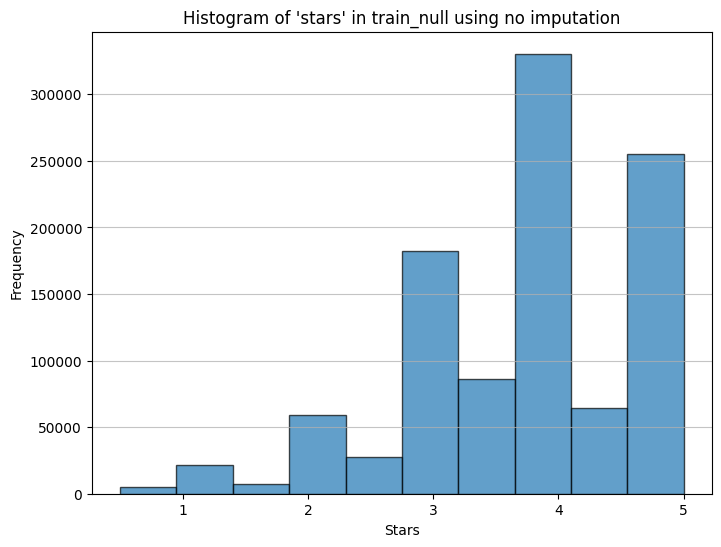

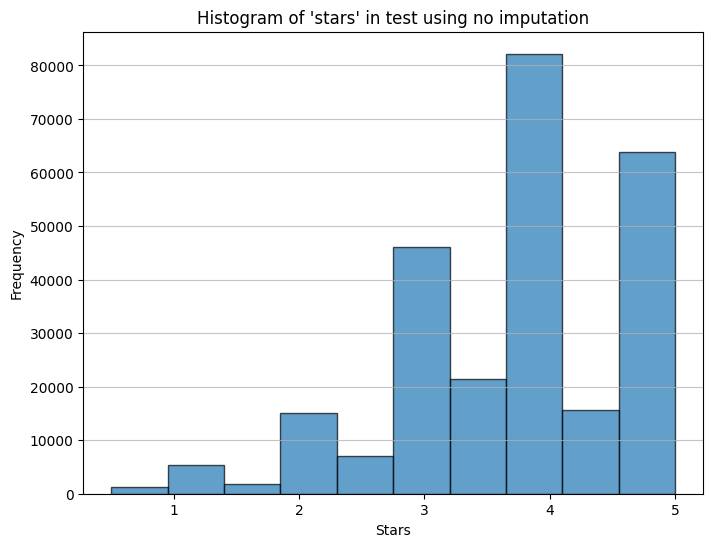

In [ ]:
# Function to plot histogram for 'stars'
def plot_stars_histogram(dataframe, data_name, imp_method_name):
    plt.figure(figsize=(8, 6))
    dataframe['stars'].plot(kind='hist', bins=10, alpha=0.7, edgecolor='black')
    plt.title(f"Histogram of 'stars' in {data_name} using {imp_method_name}")
    plt.xlabel('Stars')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

# Plot histograms for train_null, train, and test
plot_stars_histogram(train_null, "train_null", "no imputation")
plot_stars_histogram(test, "test", "no imputation")


Baseline with Median imputation

Median value used for imputation: 4.0


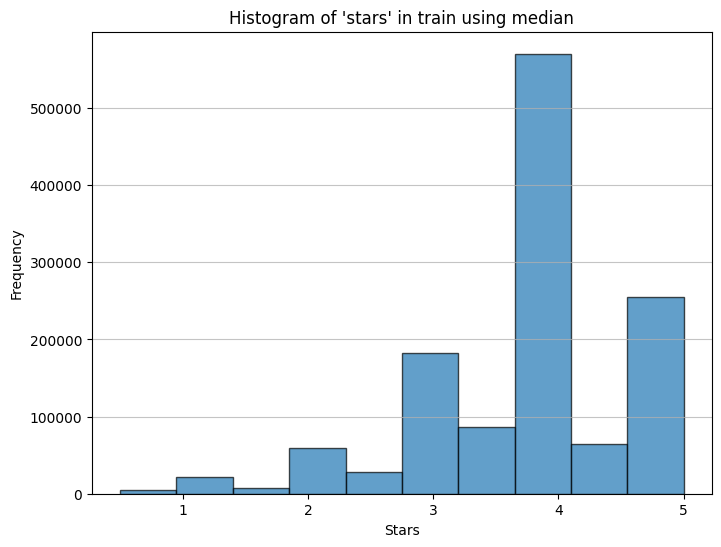

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 11.8min finished


Best Parameters: {'n_factors': 15, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.04}
Number of ratings in train set: 1278900
Number of ratings in test set: 259780
Training SVD model with best parameters . . . . 
RMSE: 0.8834
Baseline RMSE: 0.8833693351757426


Idea 1: Impute with sentiment scores



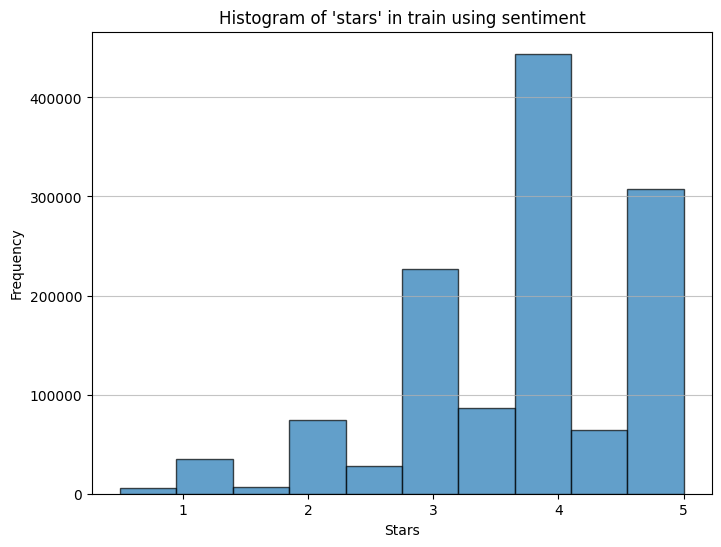

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 11.7min finished


Best Parameters: {'n_factors': 15, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.04}
Number of ratings in train set: 1278900
Number of ratings in test set: 259780
Training SVD model with best parameters . . . . 
RMSE: 0.8836
Idea 1 RMSE: 0.8835635661266489


In [ ]:
# Apply baseline

print("\nBaseline with Median imputation\n")

train = impute_missing_ratings(train_null.copy(), 'median')
plot_stars_histogram(train, "train", 'median')
rmse, predictions = svd_with_custom_split(train, test)    # rmse -> mae
print(f"Baseline RMSE: {rmse}")
#print(f"Baseline MAE: {mae}")


# SVD + SA idea 1

print("\n\nIdea 1: Impute with sentiment scores\n")

train = impute_missing_ratings(train_null.copy(), 'sentiment')
plot_stars_histogram(train, "train", 'sentiment')
rmse, predictions = svd_with_custom_split(train, test)    # rmse -> mae
print(f"Idea 1 RMSE: {rmse}")
#print(f"Idea 1 MAE: {mae}")

In [ ]:
# SVD + SA idea 2

# Impute missing stars with weighted average of sentiment_score_bert and non-null stars
def weighted_average_imputation(train, beta=0.5):
    train['stars'] = train.apply(
        lambda row: (1 - beta) * row['stars'] + beta * row['sentiment_score_bert'] if pd.notnull(row['stars']) else row['sentiment_score_bert'],
        axis=1
    )
    return train

from sklearn.model_selection import train_test_split

# Apply your idea 2
#train_null, test = custom_train_test_split(df_sent_ana_bert.copy())

# Beta values to test
beta_values = [0.2, 0.3, 0.5, 0.7]
rmse_beta_results = {}

# Loop through beta values and calculate RMSE
for beta in beta_values:

    print('Beta - ',beta)

    # Apply weighted average imputation
    train = weighted_average_imputation(train_null.copy(), beta)

    # Evaluate with SVD
    rmse, predictions = svd_with_custom_split(train, test)

    # Store RMSE for this beta
    rmse_beta_results[beta] = rmse

    print(f"Beta: {beta}, RMSE: {rmse}\n\n")

# best beta
best_beta = min(rmse_beta_results, key=rmse_beta_results.get)
best_rmse = rmse_beta_results[best_beta]

print(f"\nIdea 2 best Beta: {best_beta} with best RMSE: {best_rmse}")

Beta -  0.2


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 12.2min finished


Best Parameters: {'n_factors': 15, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.04}
Number of ratings in train set: 1278900
Number of ratings in test set: 259780
Training SVD model with best parameters . . . . 
RMSE: 0.8879
Beta: 0.2, RMSE: 0.8879430236540972


Beta -  0.3


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 11.2min finished


Best Parameters: {'n_factors': 15, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.04}
Number of ratings in train set: 1278900
Number of ratings in test set: 259780
Training SVD model with best parameters . . . . 
RMSE: 0.8924
Beta: 0.3, RMSE: 0.8923713049657399


Beta -  0.5


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 15.7min finished


Best Parameters: {'n_factors': 15, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.04}
Number of ratings in train set: 1278900
Number of ratings in test set: 259780
Training SVD model with best parameters . . . . 
RMSE: 0.9057
Beta: 0.5, RMSE: 0.9056745494653627


Beta -  0.7


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 12.6min finished


Best Parameters: {'n_factors': 15, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.16}
Number of ratings in train set: 1278900
Number of ratings in test set: 259780
Training SVD model with best parameters . . . . 
RMSE: 0.9258
Beta: 0.7, RMSE: 0.9257620243616661



Idea 2 best Beta: 0.2 with best RMSE: 0.8879430236540972


In [ ]:
# SVD idea 3

# Evaluate the combined predictions with ground truth
def calculate_rmse(predictions, ground_truth):

    predictions = np.array(predictions)
    ground_truth = np.array(ground_truth)

    # Calculate RMSE
    mse = np.mean((ground_truth - predictions) ** 2)
    return np.sqrt(mse)


# Combine SVD predictions with sentiment scores with beta parameter
def combine_predictions_with_sentiment(predictions, test, beta):
    test['pred_rating_svd'] = [pred.est for pred in predictions]
    test['final_rating'] = (1 - beta) * test['pred_rating_svd'] + beta * test['sentiment_score_bert']
   # print(test.head())
    return test


train = impute_missing_ratings(train_null.copy(), 'median')
rmse, predictions = svd_with_custom_split(train, test)    # rmse -> mae

print(f"RMSE from SVD predictions: {rmse}")


# Loop over different beta values
beta_values = [0.3, 0.5, 0.7]
rmse_results_3 = {}

for beta in beta_values:
    print(f"\nEvaluating for beta = {beta}")

    # Combine SVD predictions with sentiment scores from Bert
    test_combined = combine_predictions_with_sentiment(predictions, test.copy(), beta)

    # Calculate Final RMSE
    final_rmse = calculate_rmse(test_combined['final_rating'], test_combined['stars'])
    print(f"Final RMSE after combining with sentiment scores (beta={beta}): {final_rmse}")

    # Store the RMSE for this beta
    rmse_results_3[beta] = final_rmse

# Identify the best beta
best_beta = min(rmse_results_3, key=rmse_results_3.get)
print(f"\nIdea 3 best beta: {best_beta} with Final RMSE: {rmse_results_3[best_beta]}")

Median value used for imputation: 4.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  9.5min finished


Best Parameters: {'n_factors': 15, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.04}
Number of ratings in train set: 1278900
Number of ratings in test set: 259780
Training SVD model with best parameters . . . . 
RMSE: 0.8835
RMSE from SVD predictions: 0.8834631778358042

Evaluating for beta = 0.3
Final RMSE after combining with sentiment scores (beta=0.3): 0.7956627909426215

Evaluating for beta = 0.5
Final RMSE after combining with sentiment scores (beta=0.5): 0.7950830560988966

Evaluating for beta = 0.7
Final RMSE after combining with sentiment scores (beta=0.7): 0.8420957814713006

Idea 3 best beta: 0.5 with Final RMSE: 0.7950830560988966


## Conclusion -

Among all the experiments conducted, integrating sentiment analysis scores with the Singular Value Decomposition (SVD) model's predictions was the most effective, reducing the root mean square error (RMSE) by 0.11 compared to the baseline approach.